In [ ]:
import logging
from sklearn.model_selection import StratifiedKFold

def subset_train_test(X, y, results_dir, fold_index):
    # logging
    logging.basicConfig(filename=f"{results_dir}/logging.txt", level=logging.INFO)
    logging.info(
            "Running experiment %s with IDP index %d and fold index %d",
        )
    logging.info("X shape: %s", X.shape)
    logging.info("y shape: %s", y.shape)

    # creating the folds

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234321)

    logging.info(f"Starting the k-fold cross-validation")
    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        if fold != fold_index:
            continue
        print('folds')
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

    return X_train, y_train, X_test, y_test

Cox Partial Hazards Analysis

In [ ]:
import pandas as pd
def encode_start_end_CPH(feature, times_df, df):

    # 1) load the raw dates for this feature
    diagnosis = df[['IID', feature]]
    #diagnosis = pd.read_parquet('../../../randy/rfb/tidy_data/UKBiobank/dementia/lancet2024/lancet2024_preprocessed.parquet', engine = 'fastparquet', columns = ['eid', feature])

    # 2) ensure your times_df bounds are datetime
    times_df = times_df.copy()
    times_df['start_time'] = pd.to_datetime(times_df['start_time'])
    times_df['end_time']   = pd.to_datetime(times_df['end_time'])

    # 3) join on IID to get start/end for every person
    # Ensure diagnosis date is in datetime
    diagnosis = diagnosis.rename(columns={'IID':'eid'})
    diagnosis = diagnosis.merge(times_df, on='eid', how='inner')
    diagnosis[feature] = pd.to_datetime(diagnosis[feature], errors='coerce')

    # 4) build the interval rows
    intervals = []
    for _, row in diagnosis.iterrows():
        eid   = row['eid']
        start = row['start_time']
        end   = row['end_time']
        dx    = row[feature] # date of diagnosis

        if pd.isna(dx) or dx > end:
            # never diagnosed within window
            intervals.append({
                'eid': eid,
                'start_time': start,
                'end_time': end,
                'diagnosis': 0
            })
        else:
            intervals.append({
                'eid': eid,
                'start_time': start,
                'end_time': dx,
                'diagnosis': 1
            })

    encoded = pd.DataFrame(intervals)

    # 5) pull in every other column from df (snps, duration, groups, etc.)
    #    drop start_time/end_time there so we don’t overwrite our intervals
    meta = df.drop(columns=['start_time','end_time'], errors='ignore')
    encoded = encoded.rename(columns={'eid': 'IID'})
    encoded = encoded.merge(meta, on='IID', how='left')

    return encoded


## CPH

getting c-index

In [9]:
import joblib

model = joblib.load('./results_survival/cph_lancets/0/cph_lancets_model.joblib')

In [1]:
import joblib
model = joblib.load('./results_survival/cph_lancets_sksurv/0/sksurv_model.joblib')

In [4]:
model.feature_names_in_

array(['hypertension', 'obesity', 'diabetes', 'hearing_loss',
       'head_injury', 'freq_friends_family_visit', 'depression',
       'alcohol_consumption', '5901-0.0', '4700-0.0', '1558-0.0',
       '2020-0.0', '1031-0.0', '24018-0.0', '24011-0.0', '24015-0.0',
       '24012-0.0', '24019-0.0', '30780-0.0', '24006-0.0', 'curr_age',
       '31-0.0', 'e3/e3', 'e2/e3', 'e3/e4', 'e2/e4', 'e4/e4', 'e2/e2',
       'mdi'], dtype=object)

In [ ]:
# concordance index

root = './results_survival/cph_lancets'

c_index = []
for fold in ["0", "1", "2", "3", "4"]:
    model = joblib.load(f'{root}/{fold}/cph_lancets_model.joblib')
    c_index.append(model.concordance_index_)

avg_cindex = sum(c_index) / len(c_index)
std_cindex = (sum((x - avg_cindex) ** 2 for x in c_index) / len(c_index)) ** 0.5

In [ ]:
avg_cindex, std_cindex

to generate "kaplan meiers"

In [17]:
import pandas as pd

lancets = pd.read_parquet('../../../../randy/rfb/tidy_data/UKBiobank/dementia/lancet2024/lancet2024_preprocessed.parquet', engine = 'fastparquet')

# Extract the left-hand values (column names) from the commented lines
lancet_cols = [
    'eid',
    'hypertension',
    'obesity',
    'diabetes',
    'hearing_loss',
    'head_injury',
    'freq_friends_family_visit',
    'depression',
    'alcohol_consumption',
    '5901-0.0',
    '4700-0.0',
    '1558-0.0',
    '2020-0.0',
    '1031-0.0',
    '24018-0.0',
    '24011-0.0',
    '24015-0.0',
    '24012-0.0',
    '24019-0.0',
    '30780-0.0',
    '24006-0.0'
]
lancets = lancets[lancet_cols].dropna()

In [21]:
import argparse
import pandas as pd
import os
from datetime import datetime
import numpy as np
from ml_exp import pull_alzheimer_only
import joblib
from lifelines import CoxPHFitter, KaplanMeierFitter
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from doubleml_utils import subset_train_test

# df = pd.read_parquet('./snp_parquets/raw_allsnps_AD.parquet', engine = 'fastparquet') # IID
ddf = pd.read_parquet('allcausedementia.parquet', engine = 'fastparquet') # eid

df = pd.read_parquet('../../../../randy/rfb/tidy_data/UKBiobank/dementia/lancet2024/lancet2024_preprocessed.parquet', engine = 'fastparquet', 
                     columns = lancet_cols)

demographics = pd.read_parquet('demographics.parquet', engine = 'fastparquet', columns = ['eid', '53-0.0']) # eid
demographics['53-0.0'] = pd.to_datetime(demographics['53-0.0'], errors='coerce')
demographics = demographics.dropna(subset=['53-0.0'])

 # add start and end times to df
times_df = pd.DataFrame({
    'eid': df['eid'],
    'start_time': demographics['53-0.0'], 
    'end_time':   datetime(2025,1,1),

})

df = df.merge(times_df, on ='eid', how='left')
df = df.dropna(subset=['eid'])
df = df.rename(columns={'eid': 'IID'})


In [22]:
covariates = pd.read_parquet('doubleML_covariates.parquet', engine = 'fastparquet', 
                                 columns=['IID', 'curr_age', '31-0.0', 'e3/e3', 'e2/e3', 'e3/e4', 'e2/e4', 'e4/e4', 'e2/e2', 'mdi', 'education_years']) # eid
df = df.merge(covariates, on='IID', how='left')
df.dropna(subset=['education_years'], inplace=True)

In [23]:
# encode duration until alzheimer's diagnosis
df = pull_alzheimer_only(df, ddf) # assign
df = df.merge(
    ddf[['eid', '131036-0.0']].rename(columns={'eid': 'IID', '131036-0.0': 'diagnosis_date'}),
    on ='IID',
    how='left'
)

df['diagnosis_date'] = pd.to_datetime(df['diagnosis_date'], errors='coerce')

# assign duration: if group==1, duration = diagnosis_date - start_time, else duration = end_time - start_time
df = df.merge(ddf[['eid', '131036-0.0']], left_on='IID', right_on='eid', how='left')
df['duration'] = np.where(
    df['groups'] == 1,
    (df['diagnosis_date'] - df['start_time']).dt.days,
    (df['end_time'] - df['start_time']).dt.days
)
df = df[df['duration'] >= 0].copy()  # filter out negative durations
df = df.drop(columns=['131036-0.0'])

# impute
cols_to_drop = df.isna().mean()[df.isna().mean() > 0.1].index
df = df.drop(columns=cols_to_drop)

snp_cols = df.columns[df.columns.str.startswith('rs')]
df[snp_cols] = df[snp_cols].fillna(0)

# some randome cleaning and shit
df = df.drop(columns=['FID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE', 'diagnosis_date', 'start_time', 'end_time'], errors = 'ignore') # diagnosis

# to use with scikit survival, change groups 01 to true false
df['groups'] = df['groups'].astype(bool)
df['duration'] = df['duration'].astype(float)

In [24]:
df = df.dropna()

In [95]:
df.drop(columns=['IID', 'groups', 'duration'], inplace=True, errors='ignore')

### Obtaining metrics for sksurvival

In [ ]:
# Better binarization approach for different variable types
import numpy as np
from sklearn.metrics import roc_curve

def binarize_by_youdens(X_train, X_test, y_train): 
# Variables that are already binary (0/1)
    binary_vars = ['hypertension', 'obesity', 'diabetes', 'hearing_loss', 'head_injury', 'depression']

    # Variables that need custom binarization
    for col in lancet_cols:
        if col in X_train.columns:
            if col in binary_vars:
                # Already binary, keep as-i
                continue
            else:
                if len(X_train[col].unique()) > 10:  # Continuous-like
                    # Use ROC-based threshold only for truly continuous variables
                    try:
                        fpr, tpr, thresholds = roc_curve(y_train, X_train[col])
                        youden_j = tpr - fpr
                        best_thresh = thresholds[np.argmax(youden_j)]
                        
                        X_train.loc[:, col] = (X_train[col] >= best_thresh).astype(int)
                        X_test.loc[:, col] = (X_test[col] >= best_thresh).astype(int)
                    except:
                        # Fallback to median split
                        median_val = X_train[col].median()
                        X_train.loc[:, col] = (X_train[col] >= median_val).astype(int)
                        X_test.loc[:, col] = (X_test[col] >= median_val).astype(int)
                
    
    return X_train, X_test

In [26]:
import pandas as pd

# calculating hazard ratios
coefs_df = pd.DataFrame({})
for fold in ["0", "1", "2", "3", "4"]:
    model = joblib.load(f'./results_survival/cph_lancets_sksurv/{fold}/sksurv_model.joblib')
    coefs_df = pd.concat([coefs_df, pd.DataFrame({
        f'feature_{fold}': model.feature_names_in_,
        f'coefficient_{fold}': model.coef_,
    })], axis=1)

# Calculate mean and standard deviation of coefficients across folds
coef_cols = [col for col in coefs_df.columns if col.startswith("coefficient")]
coefs_df['mean_coef'] = coefs_df[coef_cols].mean(axis=1)
coefs_df['sd_coef'] = coefs_df[coef_cols].std(axis=1)


In [27]:
coefs_df = coefs_df.T.drop_duplicates().T

In [28]:
coefs_df

,feature_0,coefficient_0,coefficient_1,coefficient_2,coefficient_3,coefficient_4,mean_coef,sd_coef
0,hypertension,0.20772,0.204333,0.201313,0.206534,0.157952,0.19557,0.02117
1,obesity,-0.168023,-0.17895,-0.188176,-0.191446,-0.194557,-0.184231,0.01078
2,diabetes,0.320042,0.320748,0.352434,0.373959,0.371541,0.347745,0.026324
3,hearing_loss,0.229527,0.230771,0.25507,0.207832,0.215093,0.227659,0.018135
4,head_injury,1.205887,1.200671,1.198203,1.193344,1.218942,1.203409,0.009789
5,freq_friends_family_visit,-0.026415,-0.000891,-0.020496,-0.008199,-0.005921,-0.012385,0.010654
6,depression,0.821583,0.863486,0.843617,0.876999,0.867306,0.854598,0.022096
7,alcohol_consumption,-0.057278,-0.061583,-0.065817,0.018685,0.012777,-0.030643,0.042492
8,5901-0.0,0.454628,0.63078,0.50439,0.429194,0.618901,0.527579,0.09291
9,4700-0.0,-0.068844,-0.085825,-0.250315,-0.005811,-0.072803,-0.096719,0.091274


In [29]:
from sksurv.metrics import concordance_index_censored, cumulative_dynamic_auc
import matplotlib.pyplot as plt
import joblib

trains = {}
models = {}
tests = {}
c_indexes = []
aucs = []

colors = ["blue", "orange", "green", "red", "purple"]

results_dir = './results_survival/cph_lancets_sksurv'

for fold in ["0", "1", "2", "3", "4"]:
    model = joblib.load(f'./results_survival/cph_lancets_sksurv/{fold}/sksurv_model.joblib')
    X_train, y_train, X_test, y_test = subset_train_test(df, df['groups'], results_dir, int(fold))
    
    # Prepare features for prediction (drop non-feature columns)
    X_test_features = X_test.drop(columns=["groups", "duration", "IID"], errors='ignore')
    pred_risk = model.predict(X_test_features)

    # Calculate C-index
    c_index = concordance_index_censored(y_test, X_test['duration'], pred_risk)
    c_indexes.append(c_index[0])
    
    # Calculate time-dependent AUC
    # Define time points where you want to evaluate AUC (in days)
    time_points = np.array([365 * i for i in range(1, 11)])  # 1 to 10 years in days
    
    try:
        # Convert to structured arrays for scikit-survival
        from sksurv.util import Surv
        y_train_surv = Surv.from_dataframe("groups", "duration", X_train)
        y_test_surv = Surv.from_dataframe("groups", "duration", X_test)
        
        auc_scores, mean_auc = cumulative_dynamic_auc(
            y_train_surv,  # Training survival data (structured array)
            y_test_surv,   # Test survival data (structured array) 
            pred_risk,     # Risk scores from model
            time_points    # Time points to evaluate AUC
        )
        aucs.append(mean_auc)
        print(f"Fold {fold}: C-index = {c_index[0]:.3f}, Mean AUC = {mean_auc:.3f}")
        print(f"  AUC at time points {time_points}: {auc_scores}")

    except Exception as e:
        print(f"Fold {fold}: AUC calculation failed: {e}")
        aucs.append(np.nan)

    X_train, X_test = binarize_by_youdens(X_train, X_test, y_train)

    tests[fold] = X_test
    trains[fold] = X_train
    models[fold] = model

# Calculate average metrics across folds
avg_cindex = sum(c_indexes) / len(c_indexes)
std_cindex = np.std(c_indexes)

# Calculate average AUC (excluding NaN values)
valid_aucs = [auc for auc in aucs if not np.isnan(auc)]
if valid_aucs:
    avg_auc = sum(valid_aucs) / len(valid_aucs)
    std_auc = np.std(valid_aucs)
    print(f"\nCross-validation results:")
    print(f"Average C-index: {avg_cindex:.3f} ± {std_cindex:.3f}")
    print(f"Average AUC: {avg_auc:.3f} ± {std_auc:.3f}")
else:
    print(f"\nCross-validation results:")
    print(f"Average C-index: {avg_cindex:.3f} ± {std_cindex:.3f}")
    print("AUC calculation failed for all folds")
    


Fold 0: C-index = 0.884, Mean AUC = 0.886
  AUC at time points [ 365  730 1095 1460 1825 2190 2555 2920 3285 3650]: [0.50116005 0.87471221 0.8864469  0.88968328 0.88197947 0.87170665
 0.8766479  0.88586187 0.89083665 0.90354467]
Fold 1: C-index = 0.873, Mean AUC = 0.879
  AUC at time points [ 365  730 1095 1460 1825 2190 2555 2920 3285 3650]: [0.96498138 0.88817854 0.88521503 0.88317469 0.88340783 0.87612473
 0.86917724 0.87995943 0.87686958 0.88006743]
Fold 2: C-index = 0.868, Mean AUC = 0.886
  AUC at time points [ 365  730 1095 1460 1825 2190 2555 2920 3285 3650]: [0.94562852 0.89140144 0.91687747 0.89927235 0.90961786 0.89656563
 0.89138745 0.88491385 0.88177486 0.87584324]
Fold 3: C-index = 0.867, Mean AUC = 0.865
  AUC at time points [ 365  730 1095 1460 1825 2190 2555 2920 3285 3650]: [0.97438849 0.92302965 0.90261819 0.86491039 0.83285103 0.84556699
 0.85687039 0.87195341 0.87050205 0.87051158]
Fold 4: C-index = 0.872, Mean AUC = 0.876
  AUC at time points [ 365  730 1095 1460 

In [35]:
X_train, X_test = binarize_by_youdens(X_train, X_test, y_train)

In [36]:
X_train['education_years']

0         15.0
1         15.0
2         17.0
5         17.0
7         16.0
          ... 
316975    19.0
316976    17.0
316977    15.0
316979    16.0
316980    15.0
Name: education_years, Length: 222406, dtype: float64

In [15]:
import joblib

model = joblib.load('./results_survival/cph_lancets_sksurv/0/sksurv_model.joblib')

In [12]:
pred_risk = model.predict(X_test.drop(columns=["groups", "duration", "IID"], errors='ignore'))

Processing hypertension...
Processing obesity...
Processing diabetes...
Processing hearing_loss...
Processing head_injury...
Processing freq_friends_family_visit...
Processing depression...
Processing alcohol_consumption...
Processing 1031-0.0...
Processing 2020-0.0...
Processing 1558-0.0...
Processing 24018-0.0...
Processing 5901-0.0...
Processing 4700-0.0...
Processing 24019-0.0...
Processing 30780-0.0...
Processing 24006-0.0...
Processing education_years...


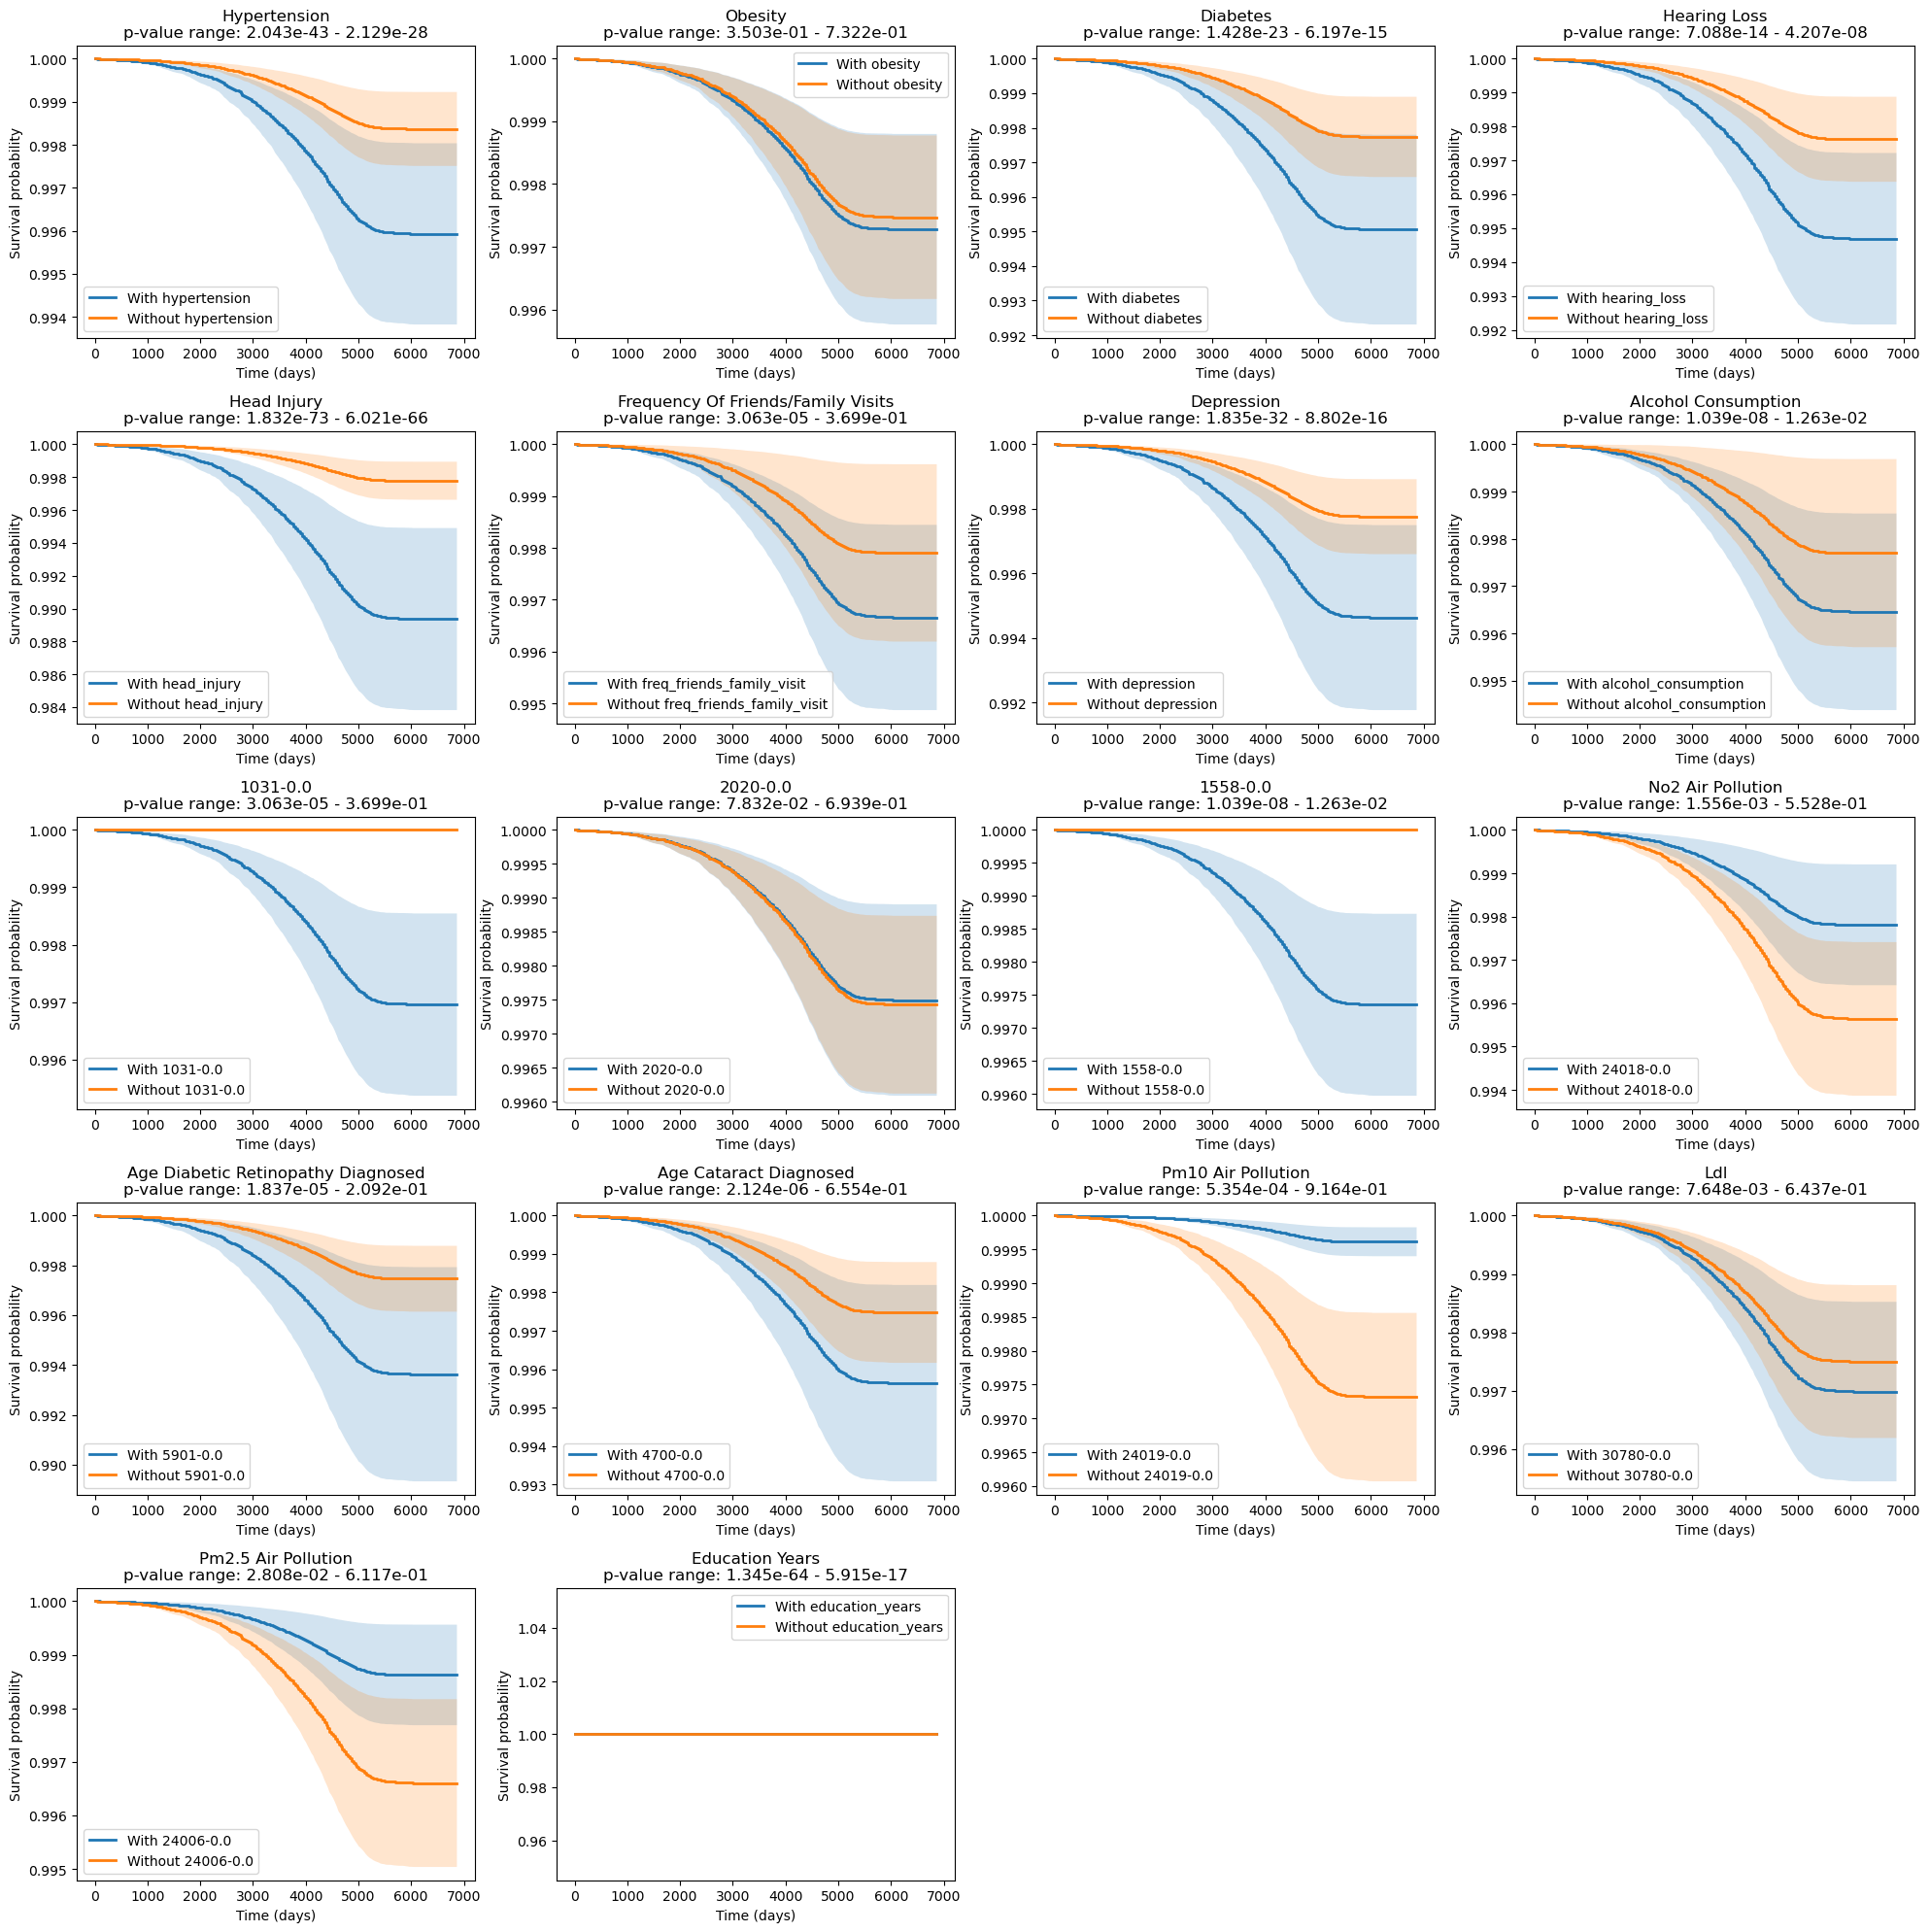

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sksurv.compare import compare_survival
from doubleml_utils import rename_vars

rename = rename_vars()

def average_survival(surv_funcs, mask):
        # Convert mask to numpy array to ensure proper indexing
        mask_array = mask.values if hasattr(mask, 'values') else mask
        # Get indices where mask is True
        selected_indices = [i for i, selected in enumerate(mask_array) if selected]
        
        # Check if we have any subjects in this group
        if not selected_indices:
            # Return array of ones (no events) if no subjects in group
            return np.ones_like(surv_funcs[0].y)
        
        # stack survival probabilities for selected patients
        curves = np.vstack([surv_funcs[i].y for i in selected_indices])
        return curves.mean(axis=0)   # average survival across patients

factors =     ['hypertension',
    'obesity',
    'diabetes',
    'hearing_loss',
    'head_injury',
    'freq_friends_family_visit',
    'depression',
    'alcohol_consumption',
    #'1031-0.0', 
    '2020-0.0', 
    #'1558-0.0', 
    '24018-0.0', 
    '5901-0.0',
    '4700-0.0',
    '24019-0.0',
    '30780-0.0',
    '24006-0.0',
    'education_years'
] # exclude 'eid'

n_factors = len(factors)
n_cols = 4
n_rows = int(np.ceil(n_factors / n_cols))

# Create subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
axes = axes.flatten()

# Store p-values and hazard ratios for each factor across folds
p_values_summary = {}
hazard_ratios_summary = {}

for idx, factor in enumerate(factors): 
    print(f"Processing {factor}...")
    ax = axes[idx]
    
    fold_results = []
    all_times = []
    p_values_folds = []  # Store p-values for this factor across folds
    hazard_ratios_folds = []  # Store hazard ratios for this factor across folds
    
    # Process each fold
    for fold_key in tests.keys():
        fold_test_data = tests[fold_key]
        fold_model = models[fold_key]

        # Get survival functions for this fold
        # Only drop columns that exist in the dataframe
        cols_to_drop = [col for col in ['IID', "groups", "duration"] if col in fold_test_data.columns]
        test_features = fold_test_data.drop(columns=cols_to_drop)
        surv_funcs = fold_model.predict_survival_function(test_features)
        times = surv_funcs[0].x  # time grid for this fold
        all_times.append(times)
    
        # Create masks for this factor
        mask = fold_test_data[factor] == 1
        no_mask = fold_test_data[factor] == 0

        # Calculate p-value using compare_survival
        try:
            # Create structured array for survival data
            from sksurv.util import Surv
            y_fold = Surv.from_dataframe("groups", "duration", fold_test_data)
            group_indicator = fold_test_data[factor].values
            
            # Compare survival between groups (0 vs 1)
            chisq, p_value = compare_survival(y_fold, group_indicator)
            p_values_folds.append(p_value)
            
        except Exception as e:
            print(f"  P-value calculation failed for fold {fold_key}: {e}")
            p_values_folds.append(np.nan)

        # Average within fold
        avg_with = average_survival(surv_funcs, mask)
        avg_without = average_survival(surv_funcs, no_mask)

        fold_results.append((times, avg_with, avg_without))
    
    # Create common time grid across all folds
    max_time = max(t.max() for t in all_times)
    min_time = min(t.min() for t in all_times)
    common_times = np.linspace(min_time, max_time, 200)
    
    # Interpolate all fold results to common time grid
    interpolated_with = []
    interpolated_without = []
    
    for times, avg_with, avg_without in fold_results:
        # Interpolate to common time grid
        interp_with = np.interp(common_times, times, avg_with)
        interp_without = np.interp(common_times, times, avg_without)
        
        interpolated_with.append(interp_with)
        interpolated_without.append(interp_without)
    
    # Average across folds
    final_avg_with = np.mean(interpolated_with, axis=0)
    avg_with_sd = np.std(interpolated_with, axis=0)
    final_avg_without = np.mean(interpolated_without, axis=0)
    avg_without_sd = np.std(interpolated_without, axis=0)
    
    # Calculate p-value statistics across folds
    valid_p_values = [p for p in p_values_folds if not np.isnan(p)]
    if valid_p_values:
        min_p = min(valid_p_values)
        max_p = max(valid_p_values)
        mean_p = np.mean(valid_p_values)
        p_values_summary[factor] = {
            'min': min_p,
            'max': max_p, 
            'mean': mean_p,
            'n_folds': len(valid_p_values)
        }
        p_range_text = f"p-value range: {min_p:.3e} - {max_p:.3e}"
    else:
        p_range_text = "p-value: N/A"
    
    # Plot results on the specific subplot
    ax.step(common_times, final_avg_with, where="post", label=f"With {factor}", linewidth=2)
    ax.step(common_times, final_avg_without, where="post", label=f"Without {factor}", linewidth=2)
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Survival probability")
    ax.set_title(f"{rename.get(factor, factor).replace('_', ' ').title()}\n{p_range_text}")
    ax.fill_between(common_times, final_avg_with - avg_with_sd, final_avg_with + avg_with_sd, alpha=0.2)
    ax.fill_between(common_times, final_avg_without - avg_without_sd, final_avg_without + avg_without_sd, alpha=0.2)
    ax.legend()

# Hide unused subplots
for j in range(n_factors, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()



In [ ]:
fold_index = 0
# SPLITTING 
results_dir = f'./results_survival/cph_lancets/{fold_index}'

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

print('splitting')
X_train, y_train, X_test, y_test = subset_train_test(df, df['groups'], results_dir, fold_index)

# cleaning - Apply to BOTH train and test sets consistently
print(f"Before cleaning - X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")



In [5]:
import os

models = []
survs = []
trains = []
tests = []
results_dir = './results_survival/cph_lancets'

for fold in ["0", "1", "2", "3", "4"]:
    model = joblib.load(f'{results_dir}/{fold}/cph_lancets_model.joblib')
    models.append(model)

    X_train, y_train, X_test, y_test = subset_train_test(df, df['groups'], results_dir, int(fold))
    trains.append(X_train)
    tests.append(X_test)
    # surv = model.predict_survival_function(X_test)
    # survs.append(surv)

Generating Kaplan Meier Curves

In [12]:
fold_index = '0'
X_train = binarize_by_youdens(trains[fold_index], tests[fold_index])

X_train

,IID,hypertension,obesity,diabetes,hearing_loss,head_injury,freq_friends_family_visit,depression,alcohol_consumption,5901-0.0,...,31-0.0,e3/e3,e2/e3,e3/e4,e2/e4,e4/e4,e2/e2,mdi,groups,duration
0,1000019,0,0,0,0,0,6,0,2,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.11,False,6799.0
1,1000022,1,0,0,0,0,7,0,6,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,12.91,False,6862.0
4,1000054,0,1,0,0,0,3,0,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,34.96,False,6181.0
6,1000078,0,1,0,0,0,7,0,3,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,45.29,False,5591.0
7,1000081,1,0,1,0,1,6,0,4,0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,15.20,False,5644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496941,6025176,0,0,0,0,0,4,0,6,0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,23.39,False,6052.0
496942,6025180,0,0,1,0,0,8,0,4,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.95,False,6066.0
496943,6025199,0,0,0,0,0,7,0,6,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.52,False,6330.0
496945,6025216,1,0,0,0,1,6,0,6,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,25.53,False,6285.0


In [14]:
X_train.sum(numeric_only=True)

IID                          1.176410e+12
hypertension                 1.143070e+05
obesity                      3.674600e+04
diabetes                     3.206100e+04
hearing_loss                 1.830700e+04
head_injury                  1.242800e+04
freq_friends_family_visit    2.069704e+06
depression                   3.061000e+04
alcohol_consumption          1.357847e+06
5901-0.0                     1.251000e+03
4700-0.0                     5.434000e+03
1558-0.0                     9.815370e+05
2020-0.0                     5.274300e+04
1031-0.0                     9.202130e+05
24018-0.0                    1.673900e+05
24011-0.0                    1.675010e+05
24015-0.0                    3.347420e+05
24012-0.0                    1.677520e+05
24019-0.0                    1.677120e+05
30780-0.0                    1.673990e+05
24006-0.0                    1.677080e+05
curr_age                     2.321838e+07
31-0.0                       1.531340e+05
e3/e3                        1.970

In [ ]:
X_train['obesity'].value_counts()

obesity
0    294143
Name: count, dtype: int64

In [1]:

rename = {
        "4700-0.0": 'Age Cataract Diagnosed',
        "5901-0.0": 'Age Diabetic Retinopathy Diagnosed',
        "30780-0.0": 'LDL',
        "head_injury": 'Head Injury',
        "22038-0.0": 'Min/Week Moderate Activity',
        "20161-0.0": 'Years of Smoking',
        "alcohol_consumption": 'Alcohol consumption',
        "hypertension": 'Hypertension',
        "obesity": 'Obesity',
        "diabetes": 'Diabetes',
        "hearing_loss": 'Hearing Loss',
        "depression": 'Depression',
        "freq_friends_family_visit": 'Frequency of Friends/Family Visits',
        "24012-0.0": 'Distance to Major Road',
        "24018-0.0": 'NO2 Air Pollution',
        "24019-0.0": 'PM10 Air Pollution',
        "24006-0.0": 'PM2.5 Air Pollution',
        "24015-0.0": 'Amount of Major Roads',
        "24011-0.0": 'Traffic Intensity',
        '6138-0.0': 'Education Level',
        '845-0.0': 'Age Completed Education',
        'curr_age': 'Current Age',

}

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import numpy as np

lancet_cols = [
    'hypertension',
    'obesity',
    'diabetes',
    'hearing_loss',
    'head_injury',
    'freq_friends_family_visit',
    'depression',
    'alcohol_consumption',
    # '5901-0.0',
    '4700-0.0',
    # '1558-0.0',
    # '2020-0.0',
    # '1031-0.0',
    '24018-0.0',
    '24011-0.0',
    '24015-0.0',
    '24012-0.0',
    '24019-0.0',
    '30780-0.0',
    '24006-0.0'
]

kmf = KaplanMeierFitter()
models = []

n = len(lancet_cols)
n_cols = 4
n_rows = int(np.ceil(n / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows), sharey=True)
axes = axes.flatten()

for i, factor in enumerate(lancet_cols):
    ax = axes[i]
    for group in X_train[factor].unique():
        mask = X_train[factor] == group
        kmf_model = kmf.fit(X_train.loc[mask, "duration"], X_train.loc[mask, "groups"], label=f"{factor}={group}")
        models.append(kmf_model)

    
        kmf.plot_survival_function(ax=ax, ci_show=False)
    ax.set_title(f"Stratified by {rename[factor]}")
    ax.set_xlabel("Days")
    if i % n_cols == 0:
        ax.set_ylabel("Survival probability")
    else:
        ax.set_ylabel("")

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

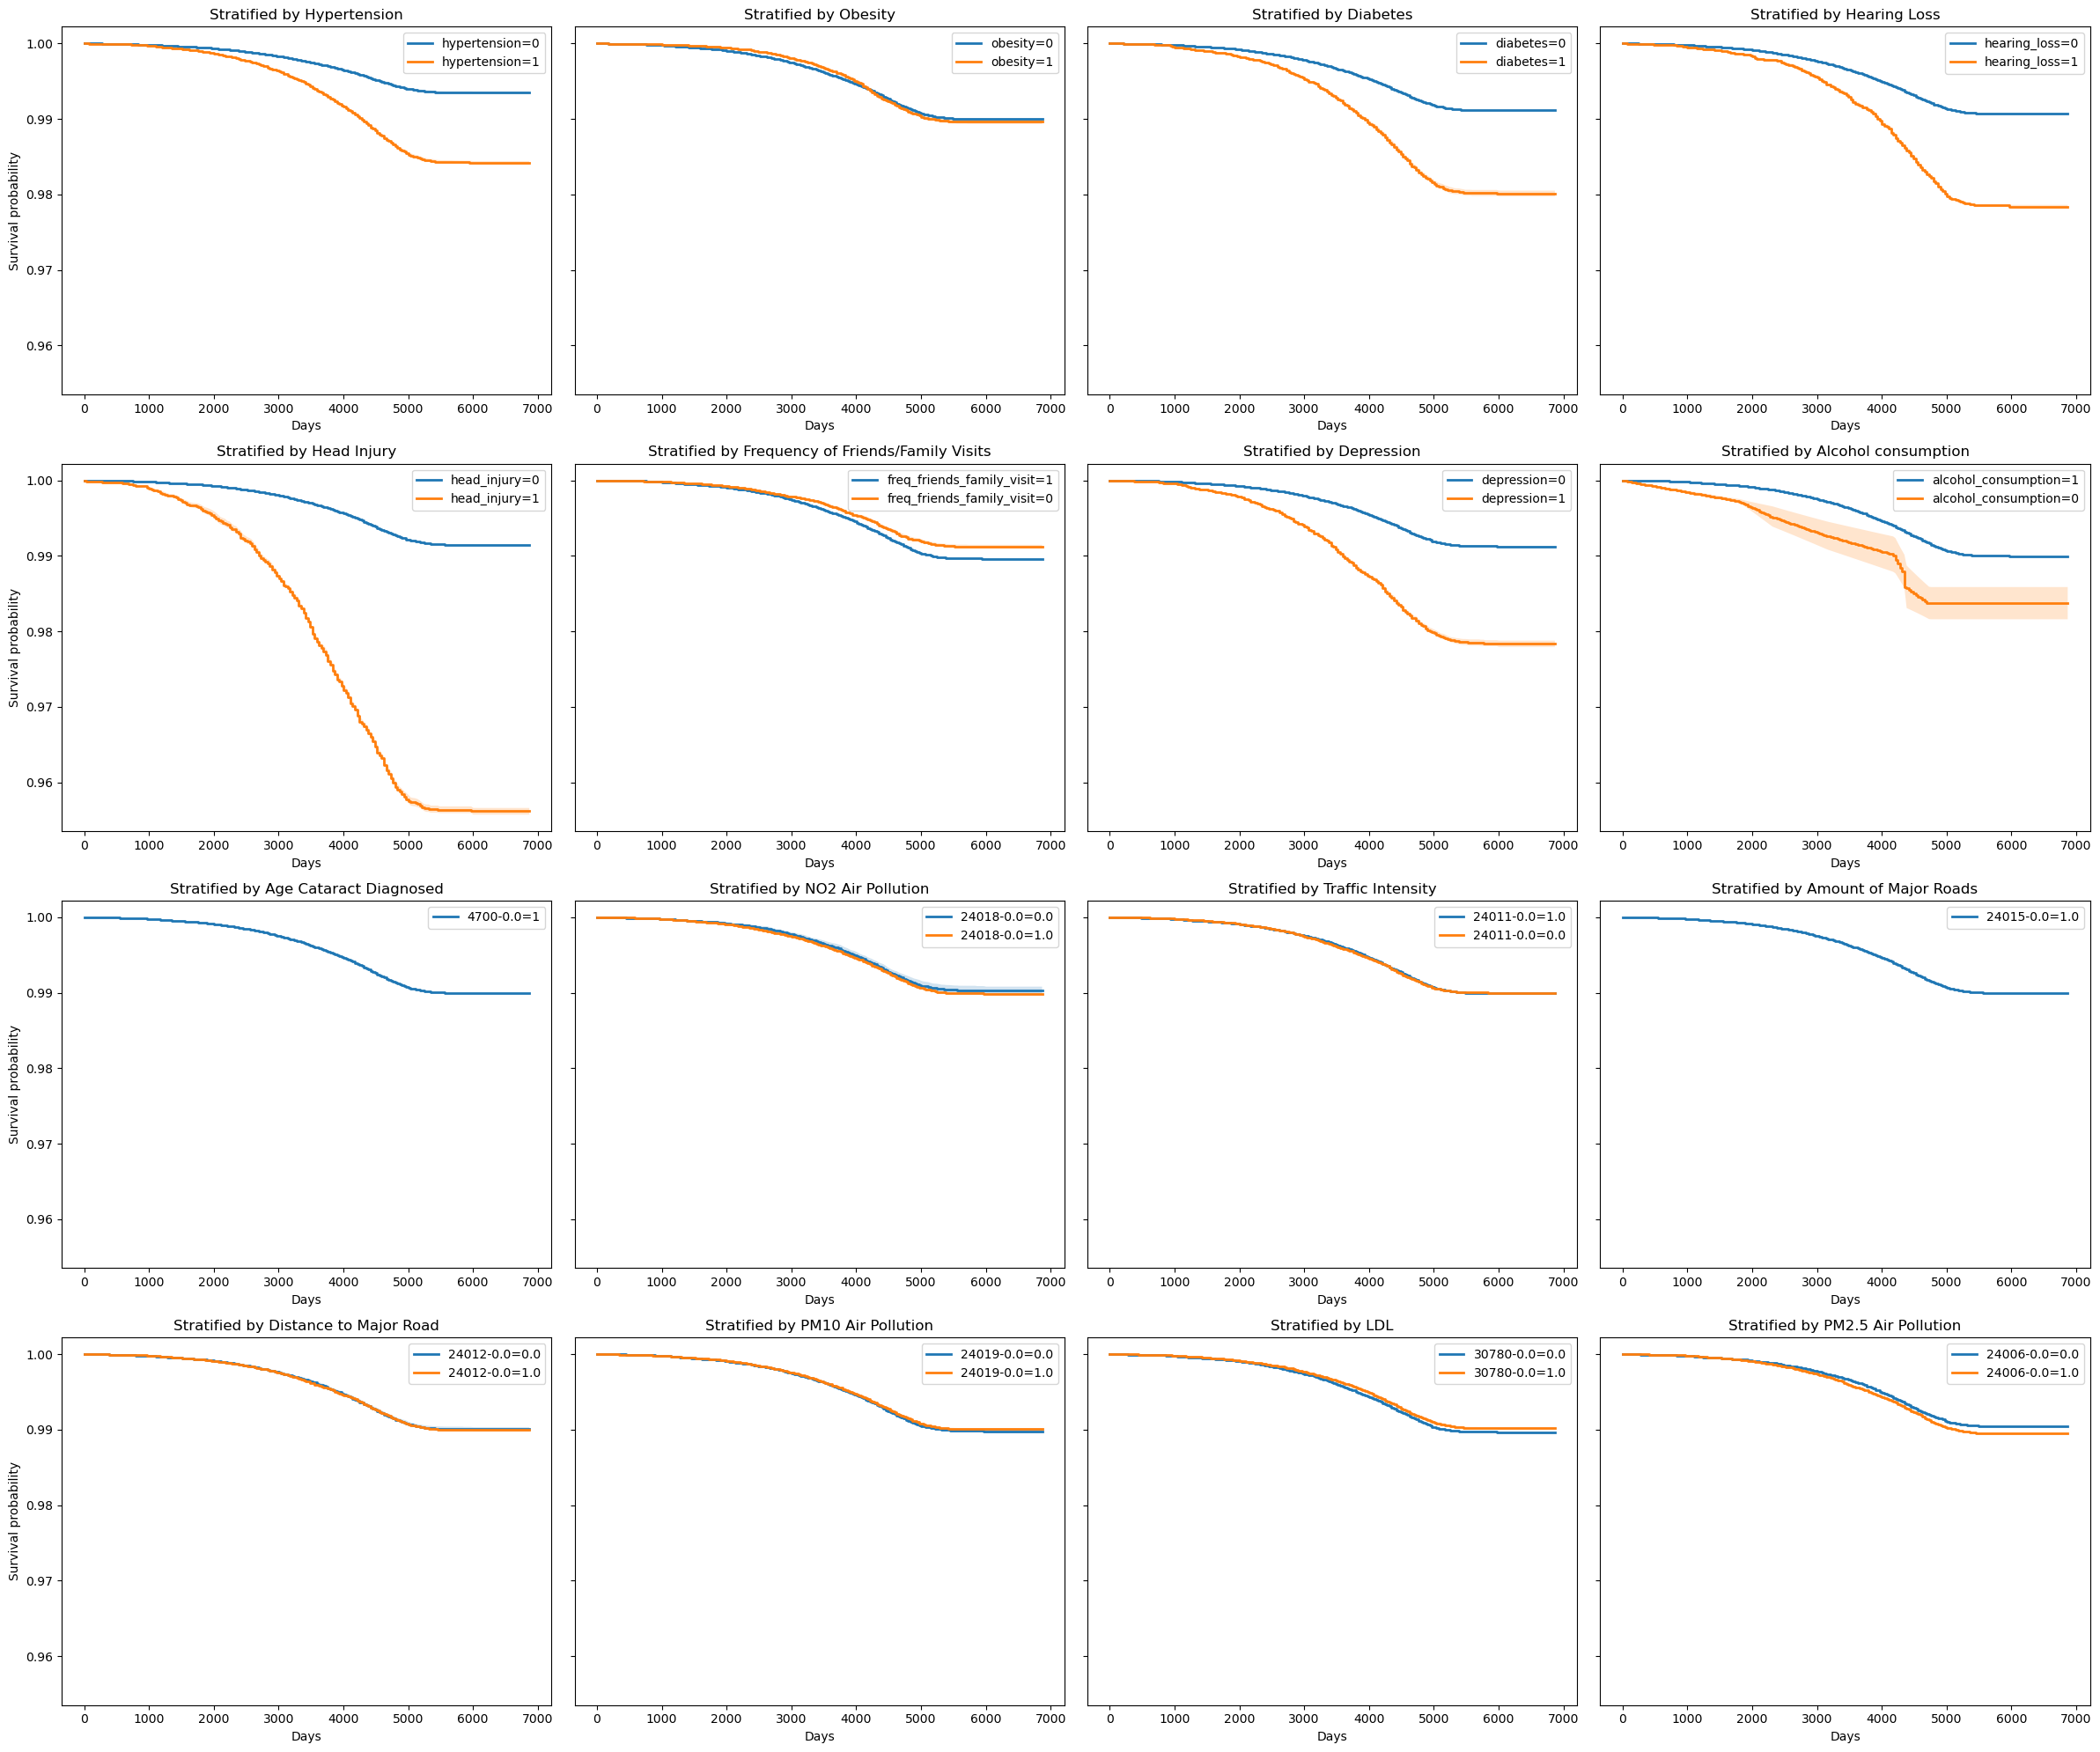

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

lancet_cols = [
    'hypertension',
    'obesity',
    'diabetes',
    'hearing_loss',
    'head_injury',
    'freq_friends_family_visit',
    'depression',
    'alcohol_consumption',
    #  '5901-0.0',
    '4700-0.0',
    # '1558-0.0',
    # '2020-0.0',
    # '1031-0.0',
    '24018-0.0',
    '24011-0.0',
    '24015-0.0',
    '24012-0.0',
    '24019-0.0',
    '30780-0.0',
    '24006-0.0'
]

def get_km_curves(df, factor, duration_col="duration", event_col="groups"):
    """Fit KM curves for all groups in df stratified by factor."""
    kmf = KaplanMeierFitter()
    curves = {}
    for group in df[factor].unique():
        mask = df[factor] == group
        kmf.fit(
            df.loc[mask, duration_col],
            df.loc[mask, event_col],
            label=f"{factor}={group}"
        )
        curves[group] = kmf.survival_function_
    return curves

n = len(lancet_cols)
n_cols = 4
n_rows = int(np.ceil(n / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows), sharey=True)
axes = axes.flatten()

folds = trains

for i, factor in enumerate(lancet_cols):
    ax = axes[i]

    # --- Collect survival curves across folds ---
    all_curves = {group: [] for group in folds[0][factor].unique()}

    for fold_idx in range(len(folds)):
        X_train = binarize_by_youdens(trains[fold_idx], tests[fold_idx])
        curves = get_km_curves(X_train, factor)
        for group, sf in curves.items():
            all_curves[group].append(sf)

    # --- Define common time grid ---
    max_time = max(sf.index.max() for curves in all_curves.values() for sf in curves)
    time_grid = np.linspace(0, max_time, 200)

    # --- Average survival curves across folds ---
    averaged_curves = {}
    std_curves = {}
    for group, sfs in all_curves.items():
        interpolated = []
        for sf in sfs:
            t = sf.index.values
            s = sf.values.flatten()
            interpolated.append(np.interp(time_grid, t, s))
        interpolated = np.array(interpolated)

        mean_curve = interpolated.mean(axis=0)
        std_curve = interpolated.std(axis=0)

        averaged_curves[group] = mean_curve
        std_curves[group] = std_curve

    # --- Plot averaged curves ---
    for group, avg_curve in averaged_curves.items():
        std_curve = std_curves[group]
        ax.step(time_grid, avg_curve, label=f"{factor}={group}", linewidth=2) 

        ax.fill_between(time_grid,
                    avg_curve - std_curve,
                    avg_curve + std_curve,
                    alpha=0.2)

    ax.set_title(f"Stratified by {rename[factor]}")
    ax.set_xlabel("Days")
    if i % n_cols == 0:
        ax.set_ylabel("Survival probability")
    else:
        ax.set_ylabel("")
    ax.legend()

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


Cox Time Varying Analysis

In [ ]:
import pandas as pd
from datetime import datetime

#ctv = pd.read_parquet('lancet_dx_dates_ctv_encoded.parquet', engine = 'fastparquet')
dx = pd.read_parquet('./snp_parquets/lancet_dx_dates.parquet', engine = 'fastparquet')

demographics = pd.read_parquet('demographics.parquet', engine = 'fastparquet', columns = ['eid', '53-0.0']) # eid

times_df = pd.DataFrame({
    'eid': demographics['eid'],
    'start_time': demographics['53-0.0'], 
    'end_time':   datetime(2023,1,1),
})

In [ ]:
#dx = dx.dropna(how='all', subset=['depression_dx', 'hypertension_dx', 'diabetes_dx', 'obesity_dx', 'ad_dx'])

In [ ]:
import pandas as pd
dx = pd.read_parquet('./snp_parquets/lancet_dx_dates.parquet', engine = 'fastparquet')


In [ ]:
dx = pd.read_parquet('./snp_parquets/lancet_dx_dates.parquet', engine = 'fastparquet')
dx = dx.astype(str)

dx_cols = dx.columns[dx.columns.str.endswith('_dx')]
for col in dx_cols:
    dx[col] = pd.to_datetime(dx[col], errors='coerce')

In [ ]:
#dx = dx.astype(str)

for col in dx.drop(columns=['eid']).columns:
    dx[col] = pd.to_datetime(dx[col], errors='coerce')
print(dx.dtypes)


In [ ]:
dx

In [ ]:
dx.to_parquet('./snp_parquets/lancet_dx_dates.parquet', engine = 'fastparquet')

In [ ]:
def build_ctv_from_diagnoses(dates_df, times_df, event_col='ad_dx'):
    # Only convert *_dx columns to date strings
    dx_cols = dates_df.columns[dates_df.columns.str.endswith('_dx')]
    for col in dx_cols:
        dates_df[col] = pd.to_datetime(dates_df[col], errors='coerce').dt.date
        dates_df[col] = dates_df[col].astype(str)
    all_ctv = []

    for eid, dx_row in dates_df.set_index('eid').iterrows():
        time_row = times_df.set_index('eid').loc[eid]

        start_time = time_row['start_time']
        end_time = time_row['end_time']
        ad_dx_date = dx_row[event_col]  # datetime of AD diagnosis (or NaT)

        time_points = [start_time]
        for col in dx_row.index:
            if col == event_col:
                continue  # skip event_col for state tracking
            date = dx_row[col]
            if pd.notna(date) and date >= start_time:
                time_points.append(date)
        if pd.notna(ad_dx_date) and ad_dx_date >= start_time:
            time_points.append(ad_dx_date)
        time_points.append(end_time)
        time_points = sorted(set(time_points))

        current_state = {col: 0 for col in dx_row.index if col != event_col}

        for i in range(len(time_points) - 1):
            t_start = time_points[i]
            t_end = time_points[i+1]

            if t_end == t_start:
                continue

            for col in current_state:
                if dx_row[col] == t_start:
                    current_state[col] = 1

            # determine if event occurred in this interval (ad_dx = 1)
            ad_dx = 1 if pd.notna(ad_dx_date) and ad_dx_date == t_end else 0

            interval = {
                'eid': eid,
                'start_time': t_start,
                'end_time': t_end,
                **current_state,
                event_col: ad_dx
            }
            all_ctv.append(interval)

    return pd.DataFrame(all_ctv)


In [ ]:
ctv = build_ctv_from_diagnoses(dx, times_df)
ctv.to_parquet('lancet_dx_dates_encoded.parquet', engine = 'fastparquet')

In [ ]:
import pandas as pd
ctv = pd.read_parquet('lancet_ctv_encoded.parquet', engine = 'fastparquet')

In [ ]:
ctv

In [ ]:
def rebase_times(df):
    df = df.copy()
    
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])

    min_start_times = df.groupby('eid')['start_time'].transform('min')

    df['start_time_days'] = (df['start_time'] - min_start_times).dt.days  
    df['end_time_days'] = (df['end_time'] - min_start_times).dt.days

    df = df.drop(columns=['start_time', 'end_time'])
    df = df.rename(columns={'start_time_days': 'start_time', 'end_time_days': 'end_time'})

    return df


In [ ]:
ctv = rebase_times(ctv)

In [ ]:
# the dfs to load

import pandas as pd
from datetime import datetime

ctv = pd.read_parquet('lancet_dx_dates_ctv_encoded.parquet', engine = 'fastparquet')
dx = pd.read_parquet('lancet_dx_dates.parquet', engine = 'fastparquet')

demographics = pd.read_parquet('demographics.parquet', engine = 'fastparquet', columns = ['eid', '53-0.0']) # eid

times_df = pd.DataFrame({
    'eid': demographics['eid'],
    'start_time': demographics['53-0.0'], 
    'end_time':   datetime(2023,1,1),
})


In [ ]:
covariates_df = pd.read_parquet('doubleML_dep_AD_covariates.parquet', engine = 'fastparquet')

covariates_df['30710-0.0'] = covariates_df['30710-0.0'].fillna(covariates_df['30710-0.0'].mean())
covariates_df['mdi'] = covariates_df['mdi'].fillna(covariates_df['mdi'].mean())

covariates_df = covariates_df.drop(columns = 'groups').rename(columns = {'IID':'eid'})

In [ ]:
ctv = ctv.merge(covariates_df, on = 'eid', how = 'inner')

In [ ]:
ctv = ctv.drop(columns = ['depression', 'curr_age'])

# scale continuous variables
# drop curr_age, depression 
# encode integers for the start/end times


In [ ]:
ctv

In [ ]:
from lifelines import CoxTimeVaryingFitter
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd


# read in dfs
df = pd.read_parquet('./snp_parquets/raw_allsnps_AD.parquet', engine = 'fastparquet') # IID
df = df.drop(columns = ['FID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE'])

ctv = pd.read_parquet('lancet_dx_dates_ctv_encoded.parquet')

df = ctv.merge(df, on = 'IID', how='left')

# # fill na for snps
# snp_cols = df.columns[df.columns.str.startswith('rs')]
# df[snp_cols] = df[snp_cols].ffill().fillna(0)



In [ ]:
import pandas as pd

dx = pd.read_parquet('./snp_parquets/lancet_dx_dates.parquet', engine = 'fastparquet')
dx

In [ ]:
from lifelines import CoxTimeVaryingFitter
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

results_dir = './results_survival/ctv_lancets'

X_train, _, _, _ = train_test_split(ctv, ctv['ad_dx'], test_size = 0.2, random_state=1928)

# X_train = X_train.drop(columns = ['rs191177039_A', 'rs183600932_C', 'rs186375628_T', 'rs141610415_T', 'rs188208995_G', 
#                                   'rs139967528_A', 'rs570487962_A', 'rs10409808_G', 'rs147525344_T', 'rs112404845_A', 'rs11687170_T', 'rs79781504_A', 'rs115038899_C'])


# =========================
# Cox Time-Varying Fitting
# =========================
ctv_model = CoxTimeVaryingFitter(penalizer=0.1)  # add slight ridge penalty

ctv_model.fit(
    X_train,
    id_col='eid',
    start_col='start_time',
    stop_col='end_time',
    event_col='ad_dx',
)

ctv_model.print_summary()
ctv_model.save_model(f"./results_survival/ctv_model_correct.pkl")

In [ ]:
cols_to_drop = df.isna().mean()[df.isna().mean() > 0.1].index
df = df.drop(columns=cols_to_drop)

In [ ]:
snp_cols = df.columns[df.columns.str.startswith('rs')]
df[snp_cols] = df[snp_cols].fillna(0)
df

In [ ]:
import matplotlib.pyplot as plt

custom_names = {
    'depression_dx': 'Depression Dx',
    'hypertension_dx': 'Hypertension Dx',
    'diabetes_dx': 'Diabetes Dx',
    'obesity_dx': 'Obesity Dx',
    'age_at_start': 'Age',
    '31-0.0': 'Sex', 
    'mdi': 'Multiple Deprivation Index',
    '30710-0.0': 'CRP (mg/L)',
    # add more mappings as needed
}

summary = ctv_model.summary.copy()
summary.index = summary.index.to_series().replace(custom_names)
summary['coef'].plot(kind='barh')
plt.xlabel('Coefficient')
plt.title('Cox Time-Varying Model Coefficients')
plt.show()

In [ ]:
print(X_train[['depression_dx', 'hypertension_dx', 'diabetes_dx', 'obesity_dx', 'groups']].corr())


In [ ]:
import pandas as pd
df = pd.read_parquet('lancet_ctv_encoded.parquet', engine = 'fastparquet')
df


In [ ]:
import joblib

model = joblib.load('./results_survival/cph_lancets/0/cph_lancets_model.joblib')

In [ ]:
import pandas as pd
df = pd.read_parquet('../../../../randy/proj_idp/tidy_data/prs_Alz/prs_Alz.parquet', engine = 'fastparquet') # eid
#df = df.drop(columns = ['FID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE'], errors = 'ignore')

ctv = pd.read_parquet('lancet_ctv_encoded.parquet', engine = 'fastparquet')

df = ctv.merge(df, on = 'eid', how='left')

In [ ]:
covariates = ['31-0.0', 'curr_age', 'e3/e3', 'e2/e3', 'e3/e4', 'e2/e4', 'e4/e4', 'education_years', 'e2/e2']

covs = pd.read_parquet('doubleML_covariates.parquet', engine='fastparquet')
covs.rename(columns={'IID':'eid'}, inplace=True)
covs = covs[['eid'] + covariates]

df = df.merge(covs, on='eid', how='inner')

df = df.dropna()

In [ ]:
model.plot()

In [ ]:
model.print_summary()